In [1]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [2]:
data = pd.read_csv('cleaned_file.csv')
data.head()

,id,brand,price,destination,checked_baggage,hand_luggage,start_hour,end_hour,trip_mins,is_holiday,days_left
0,CXR0001,VietJet Air,1892258,Nha Trang (CXR)\nSân bay Cam Ranh,0,7,Afternoon,Afternoon,60,3,17
1,CXR0001,VietJet Air,1431413,Nha Trang (CXR)\nSân bay Cam Ranh,0,7,Afternoon,Afternoon,60,3,16
2,CXR0001,VietJet Air,1327929,Nha Trang (CXR)\nSân bay Cam Ranh,0,7,Afternoon,Afternoon,60,3,15
3,CXR0001,VietJet Air,1283783,Nha Trang (CXR)\nSân bay Cam Ranh,0,7,Afternoon,Afternoon,60,3,14
4,CXR0001,VietJet Air,1285778,Nha Trang (CXR)\nSân bay Cam Ranh,0,7,Afternoon,Afternoon,60,3,13


In [3]:
data = pd.get_dummies(
    data,
    columns=[
        'start_hour',
        'end_hour',
        'hand_luggage',
        'checked_baggage'])

In [4]:
data['brand'].unique()

array(['VietJet Air', 'Vietnam Airlines', 'Bamboo Airways',
       'Vietravel Airlines'], dtype=object)

In [5]:
# Split data based on brand
Bamboo = data[data['brand'] == 'Bamboo Airways']
Vietjet = data[data['brand'] == 'VietJet Air']
Vietnam = data[data['brand'] == 'Vietnam Airlines']
Vietravel = data[data['brand'] == 'Vietravel Airlines']

# TRAIN _ TEST 

In [6]:
test_data = []


def split_train_test(data):
    train = []
    test = []

    for des in data['destination'].unique():
        df = data[data['destination'] == des]
        for i in range(2):
            id = df['id'].sample(n=1, random_state=42).values[0]
            if df['brand'].unique()[0] == 'Vietravel Airlines':
                days_left = 7
            else:
                days_left = np.random.randint(10, 15)
            flight_by_id = df[(df['id'] == id) & (
                df['days_left'] <= days_left)]
            test.append(flight_by_id)
            test_data.append(flight_by_id)
            df = df.drop(flight_by_id.index)

        sample_df = df.sample(frac=0.18, random_state=42)
        train.append(df.drop(sample_df.index))
        test.append(sample_df)
    train = pd.concat(train, ignore_index=True)
    test = pd.concat(test, ignore_index=True)
    return train, test

In [7]:
Bamboo_train, Bamboo_test = split_train_test(Bamboo)
Vietjet_train, Vietjet_test = split_train_test(Vietjet)
Vietnam_train, Vietnam_test = split_train_test(Vietnam)
Vietravel_train, Vietravel_test = split_train_test(Vietravel)

In [8]:
airlines = {
    "Bamboo": (Bamboo_train.shape, Bamboo_test.shape),
    "VietJet": (Vietjet_train.shape, Vietjet_test.shape),
    "Vietnam Airlines": (Vietnam_train.shape, Vietnam_test.shape),
    "Vietravel": (Vietravel_train.shape, Vietravel_test.shape)
}

for name, (train_shape, test_shape) in airlines.items():
    print(f"{name:<18} | Train: {train_shape}\t| Test: {test_shape}")

Bamboo             | Train: (2359, 23)	| Test: (603, 23)
VietJet            | Train: (16870, 23)	| Test: (3806, 23)
Vietnam Airlines   | Train: (16237, 23)	| Test: (3665, 23)
Vietravel          | Train: (929, 23)	| Test: (245, 23)


# OUTLIERS

In [9]:
def threshold_outlier(des, data):
    df = data[data['destination'] == des]
    q1 = df['price'].quantile(0.25)
    q3 = df['price'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [10]:
def process_outliers(data):
    for des in data['destination'].unique():
        lower, upper = threshold_outlier(des, data)
        condition = (
            (data['destination'] == des) &
            ((data['price'] < lower) | (data['price'] > upper))
        )
        data.loc[condition, 'price'] = upper
    return data

In [11]:
Bamboo_train = process_outliers(Bamboo_train)
Vietjet_train = process_outliers(Vietjet_train)
Vietnam_train = process_outliers(Vietnam_train)
Vietravel_train = process_outliers(Vietravel_train)

C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\2541786550.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3892862.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[condition, 'price'] = upper
C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\2541786550.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2040600.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[condition, 'price'] = upper
C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\2541786550.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3079702.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[condition, 'price'] = upper
C:

In [12]:
def boxplot(data):
    for des in data['destination'].unique():
        print(
            f'Destination: {des}, count: {len(data[data["destination"] == des])}')
        df = data[data['destination'] == des]
    plt.figure(figsize=(15, 5))
    sns.boxplot(x='destination', y='price', data=data, palette='hls')
    plt.title(f'Boxplot of {df['brand'].unique()[0]} by destination')
    plt.show()

Destination: Đà Nẵng (DAD)
Sân bay Đà Nẵng, count: 485
Destination: Hà Nội (HAN)
Sân bay Nội Bài, count: 1530
Destination: Hải Phòng (HPH)
Sân bay quốc tế Cát Bi, count: 153
Destination: Phú Quốc (PQC)
Sân bay Phú Quốc, count: 191


C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\135816679.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='destination', y='price', data=data, palette='hls')
) missing from font(s) DejaVu Sans.n\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


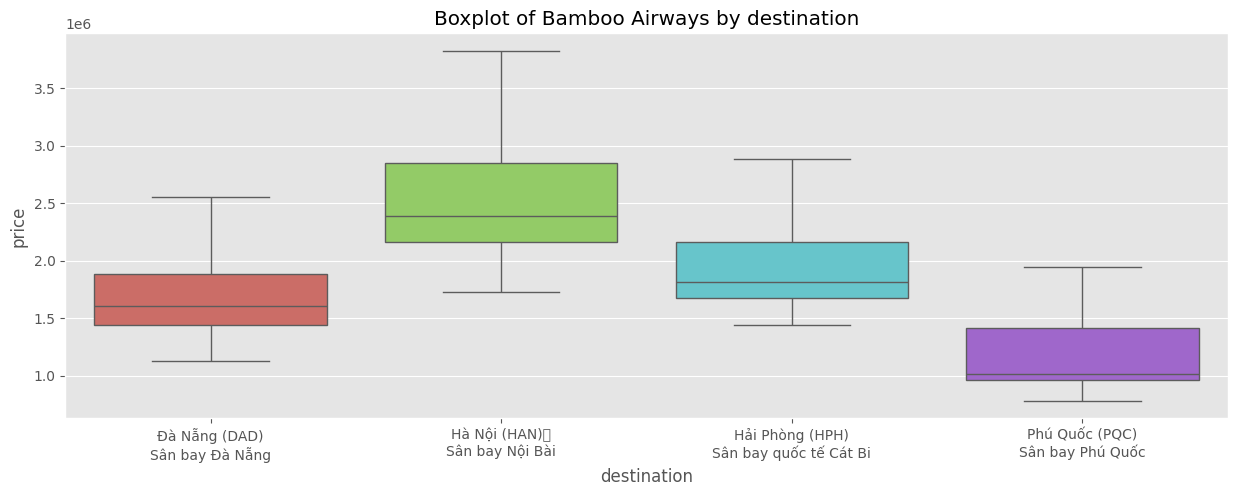

In [13]:
boxplot(Bamboo_train)

Destination: Nha Trang (CXR)
Sân bay Cam Ranh, count: 904
Destination: Đà Nẵng (DAD)
Sân bay Đà Nẵng, count: 4608
Destination: Hà Nội (HAN)
Sân bay Nội Bài, count: 7235
Destination: Hải Phòng (HPH)
Sân bay quốc tế Cát Bi, count: 2232
Destination: Phú Quốc (PQC)
Sân bay Phú Quốc, count: 1891


C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\135816679.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='destination', y='price', data=data, palette='hls')
) missing from font(s) DejaVu Sans.n\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


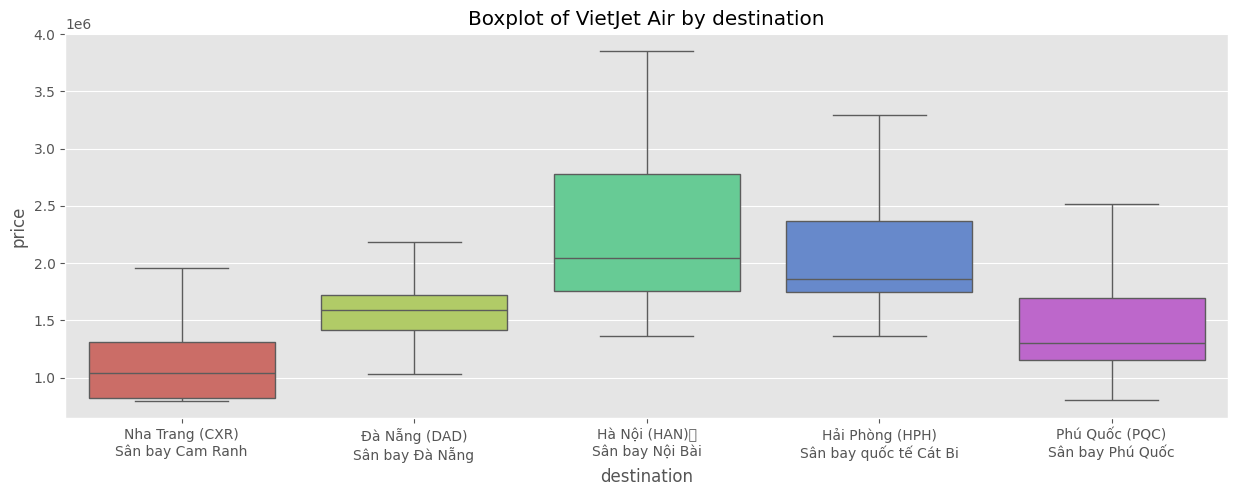

In [14]:
boxplot(Vietjet_train)

C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\135816679.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='destination', y='price', data=data, palette='hls')
) missing from font(s) DejaVu Sans.n\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


Destination: Đà Nẵng (DAD)
Sân bay Đà Nẵng, count: 320
Destination: Hà Nội (HAN)
Sân bay Nội Bài, count: 301
Destination: Phú Quốc (PQC)
Sân bay Phú Quốc, count: 308


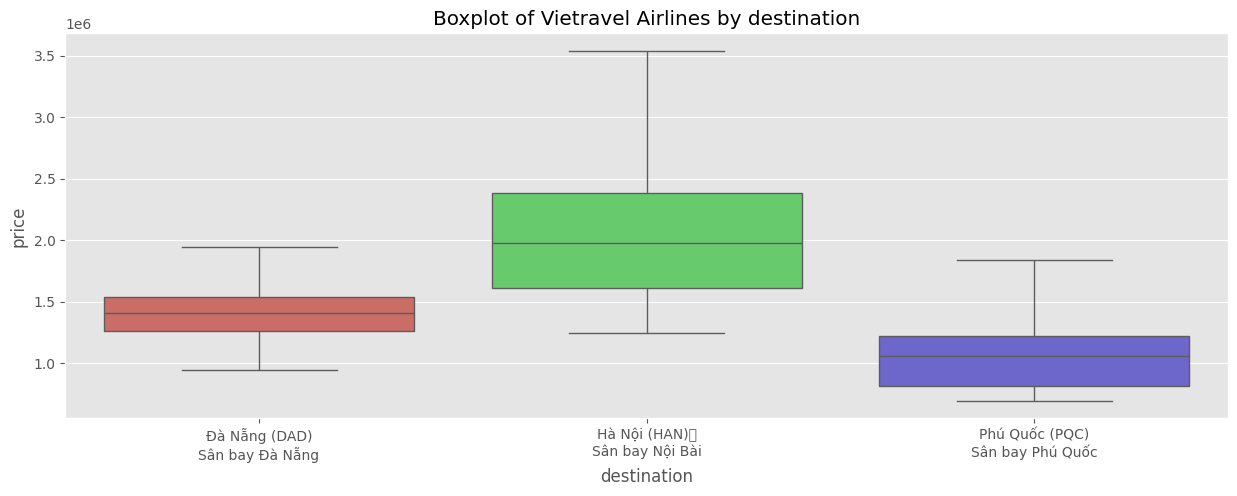

In [15]:
boxplot(Vietravel_train)

Destination: Nha Trang (CXR)
Sân bay Cam Ranh, count: 1667
Destination: Đà Nẵng (DAD)
Sân bay Đà Nẵng, count: 5015
Destination: Hà Nội (HAN)
Sân bay Nội Bài, count: 6692
Destination: Hải Phòng (HPH)
Sân bay quốc tế Cát Bi, count: 1000
Destination: Phú Quốc (PQC)
Sân bay Phú Quốc, count: 1863


C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\135816679.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='destination', y='price', data=data, palette='hls')
) missing from font(s) DejaVu Sans.n\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


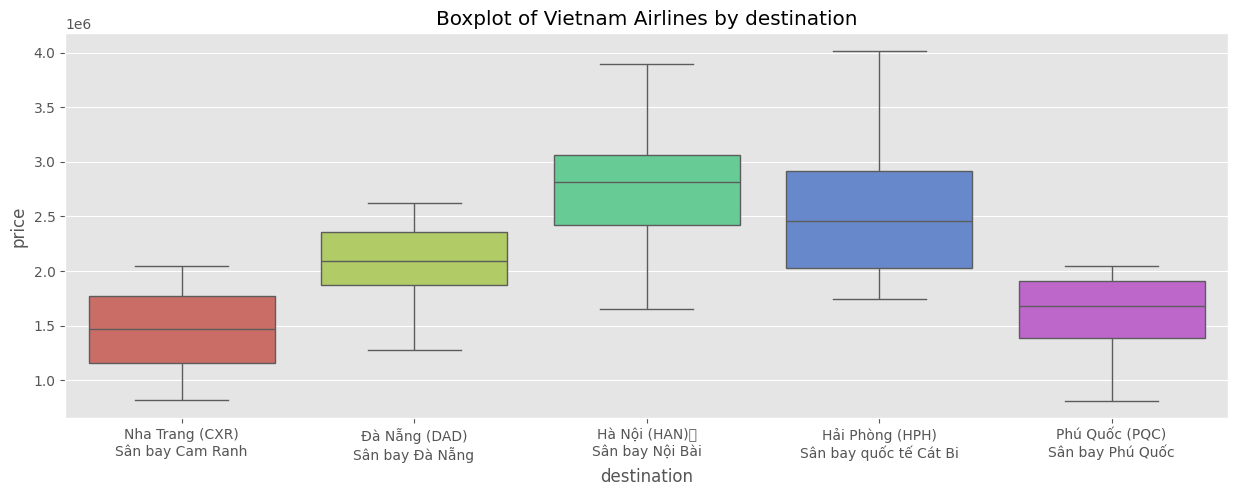

In [16]:
boxplot(Vietnam_train)

# Modeling

In [17]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    return X_train, X_test

In [18]:
modelAda = AdaBoostRegressor()
modelbag = BaggingRegressor()
modelGBR = GradientBoostingRegressor()
modeldcr = DecisionTreeRegressor()
modelrfr = RandomForestRegressor()
modelETR = ExtraTreesRegressor(n_estimators=100)

In [19]:
MM = [modelAda, modelbag, modelGBR, modeldcr, modelrfr, modelETR]
models = [
    'AdaBoost',
    'BaggingRegressor',
    'GradientBoostingRegressor',
    'DecisionTreeRegressor',
    'RandomForestRegressor',
    'ExtraTreesRegressor']


def modeling(X_train, X_test, y_train, y_test, Results, brand):
    count = 0
    for model in MM:
        # Fit the model with train data
        model.fit(X_train, y_train)

        # Predict the model with test data
        y_pred = model.predict(X_test)

        def MAPE(y_test, y_pred):
            y_test, y_pred = np.array(y_test), np.array(y_pred)
            return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        # Evaluation of MAPE
        result = MAPE(y_test, y_pred)

        new_row = {
            'Brand': brand,
            'Model Name': models[count],
            'Mean_Absolute_Error_MAE': metrics.mean_absolute_error(
                y_test,
                y_pred),
            'R2_score': round(
                metrics.r2_score(
                    y_test,
                    y_pred),
                6),
            'Mean_Absolute_Percentage_Error_MAPE': result}
        Results = pd.concat(
            [Results, pd.DataFrame([new_row])], ignore_index=True)
        count += 1
    return Results, y_pred

In [20]:
def split_and_model(train, test):
    Results = pd.DataFrame(columns=['Brand', 'Model Name', 'R2_score'])

    # Split the data into features and target variable
    X_train = train.drop(columns=['price', 'brand', 'id'])
    y_train = train['price']
    X_test = test.drop(columns=['price', 'brand', 'id'])
    y_test = test['price']

    # Convert categorical variables to dummy variables
    X_train = pd.get_dummies(X_train, columns=['destination'])
    X_test = pd.get_dummies(X_test, columns=['destination'])

    # Scale the data
    X_train, X_test = scale_data(X_train, X_test)

    # run the modeling function
    Results, y_pred = modeling(
        X_train, X_test, y_train, y_test, Results, train['brand'][0])
    return Results, y_pred

In [21]:
Bamboo_results, Bamboo_pred = split_and_model(Bamboo_train, Bamboo_test)
Vietjet_results, Vietjet_pred = split_and_model(Vietjet_train, Vietjet_test)
Vietravel_results, Vietravel_pred = split_and_model(
    Vietravel_train, Vietravel_test)
Vietnam_results, Vietnam_pred = split_and_model(Vietnam_train, Vietnam_test)

# Combine all results into a single DataFrame
all_results = pd.concat([Bamboo_results,
                         Vietjet_results,
                         Vietravel_results,
                         Vietnam_results],
                        ignore_index=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\1341295084.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Results = pd.concat(
C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\1341295084.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Results = pd.concat(
C:\Users\DELL\AppData\Local\Temp\ipykernel_15124\1341295084.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA c

**R2-Score**

In [22]:
pivot_df = all_results.pivot(
    index='Model Name',
    columns='Brand',
    values='R2_score')
pivot_df

Brand,Bamboo Airways,VietJet Air,Vietnam Airlines,Vietravel Airlines
Model Name,,,,
AdaBoost,0.882701,0.683805,0.692477,0.645582
BaggingRegressor,0.885559,0.744619,0.722139,0.651317
DecisionTreeRegressor,0.872389,0.739387,0.711312,0.614984
ExtraTreesRegressor,0.874746,0.739127,0.712159,0.617759
GradientBoostingRegressor,0.906167,0.762917,0.745188,0.723546
RandomForestRegressor,0.888040,0.746788,0.724442,0.652163


**MAPE**

In [23]:
pivot_df = all_results.pivot(
    index='Model Name',
    columns='Brand',
    values='Mean_Absolute_Percentage_Error_MAPE')
pivot_df

Brand,Bamboo Airways,VietJet Air,Vietnam Airlines,Vietravel Airlines
Model Name,,,,
AdaBoost,10.184268,16.166150,13.971393,19.666437
BaggingRegressor,9.301393,12.332348,12.311535,17.103313
DecisionTreeRegressor,9.732266,12.409785,12.473537,17.517462
ExtraTreesRegressor,9.740684,12.415119,12.475037,17.458221
GradientBoostingRegressor,8.277944,12.042915,12.260483,15.417736
RandomForestRegressor,9.293967,12.259172,12.275562,17.129805


**MAE**

In [24]:
pivot_df = all_results.pivot(
    index='Model Name',
    columns='Brand',
    values='Mean_Absolute_Error_MAE')
pivot_df

Brand,Bamboo Airways,VietJet Air,Vietnam Airlines,Vietravel Airlines
Model Name,,,,
AdaBoost,197180.125371,292557.730953,307687.698695,294530.803128
BaggingRegressor,186350.940258,237929.815549,276243.199647,269337.222427
DecisionTreeRegressor,193602.264935,239608.083685,280195.027542,275971.078484
ExtraTreesRegressor,193225.411864,239817.026028,280002.400740,276090.568188
GradientBoostingRegressor,172119.631933,232034.126306,272965.446331,239926.916842
RandomForestRegressor,185912.550513,236670.474880,275911.068685,268179.049889


# Predict

In [ ]:
def create_data(X):
    expanded_rows = []

    for _, row in X.iterrows():
        for day in range(
                row['days_left'] - 1, 0, -1):
            new_row = row.copy()
            new_row['days_left'] = day
            expanded_rows.append(new_row)

    return pd.DataFrame(expanded_rows).reset_index(drop=True)

In [26]:
def adjust(X_test, Y_test):
    for id in X_test['id'].unique():
        y_connt = Y_test[Y_test['id'] == id].value_counts()
        x_connt = X_test[X_test['id'] == id].value_counts()
        if y_connt.equals(x_connt):
            continue
        days_left = Y_test[Y_test['id'] == id]['days_left'].unique()
        X_test = X_test[~((X_test['id'] == id) & ~(
            X_test['days_left'].isin(days_left)))]
    return X_test.reset_index(drop=True)

In [27]:
def lineplot_y_pred(data):
    plt.figure(figsize=(20, 8))
    sns.lineplot(data=data, x='days_left', y='Actual Price', color='red')
    sns.lineplot(data=data, x='days_left', y='Predicted Price', color='blue')
    plt.title(
        'Days Left For Departure Versus Actual Ticket Price and Predicted Ticket Price',
        fontsize=20)
    plt.legend(
        labels=[
            'Actual Price',
            'Actual Price',
            'Predicted Price',
            'Predicted Price'],
        fontsize=19)
    plt.xlabel('Days Left for Departure', fontsize=15)
    plt.ylabel('Actual and Predicted Price', fontsize=15)
    plt.show()

In [28]:
test_data = pd.concat(test_data, ignore_index=True)

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       331 non-null    object
 1   brand                    331 non-null    object
 2   price                    331 non-null    int64 
 3   destination              331 non-null    object
 4   trip_mins                331 non-null    int64 
 5   is_holiday               331 non-null    int64 
 6   days_left                331 non-null    int64 
 7   start_hour_Afternoon     331 non-null    bool  
 8   start_hour_EarlyMorning  331 non-null    bool  
 9   start_hour_Evening       331 non-null    bool  
 10  start_hour_LateNight     331 non-null    bool  
 11  start_hour_Morning       331 non-null    bool  
 12  end_hour_Afternoon       331 non-null    bool  
 13  end_hour_EarlyMorning    331 non-null    bool  
 14  end_hour_Evening         331 non-null    b

In [30]:
def predict(brand, train):
    test = test_data[test_data['brand'] == brand].copy()
    X_test = []
    Y_test = []
    for des in test['destination'].unique():
        for id in test['id'].unique():
            df = test[(test['destination'] == des) & (test['id'] == id)
                      ].copy().sort_values(by='days_left', ascending=False)
            X_test.append(df.head(1))
            df = df.drop(df.head(1).index)
            Y_test.append(df)

    X_test = pd.concat(X_test, ignore_index=True)
    Y_test = pd.concat(Y_test, ignore_index=True)

    X_test = create_data(X_test)
    X_test_with_id = adjust(X_test, Y_test)

    X_test = X_test_with_id.drop(columns=['id', 'brand', 'price'])
    Y_test = Y_test['price']

    X_train = train.drop(columns=['price', 'brand', 'id'])
    y_train = train['price']

    X_test = pd.get_dummies(X_test, columns=['destination'])
    X_train = pd.get_dummies(X_train, columns=['destination'])

    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

    modelGBR.fit(X_train_scaled, y_train)

    y_pred = modelGBR.predict(X_test_scaled)
    output = pd.DataFrame(
        {'Actual Price': Y_test, 'Predicted Price': y_pred}, index=Y_test.index)

    result = X_test_with_id.copy()
    result['Actual Price'] = output['Actual Price']
    result['Predicted Price'] = output['Predicted Price']

    print(
        f'Brand: {brand}, R2_score: {
            round(
                metrics.r2_score(
                    Y_test,
                    y_pred),
                6)}')
    lineplot_y_pred(result)

    return result

Brand: Bamboo Airways, R2_score: 0.911088


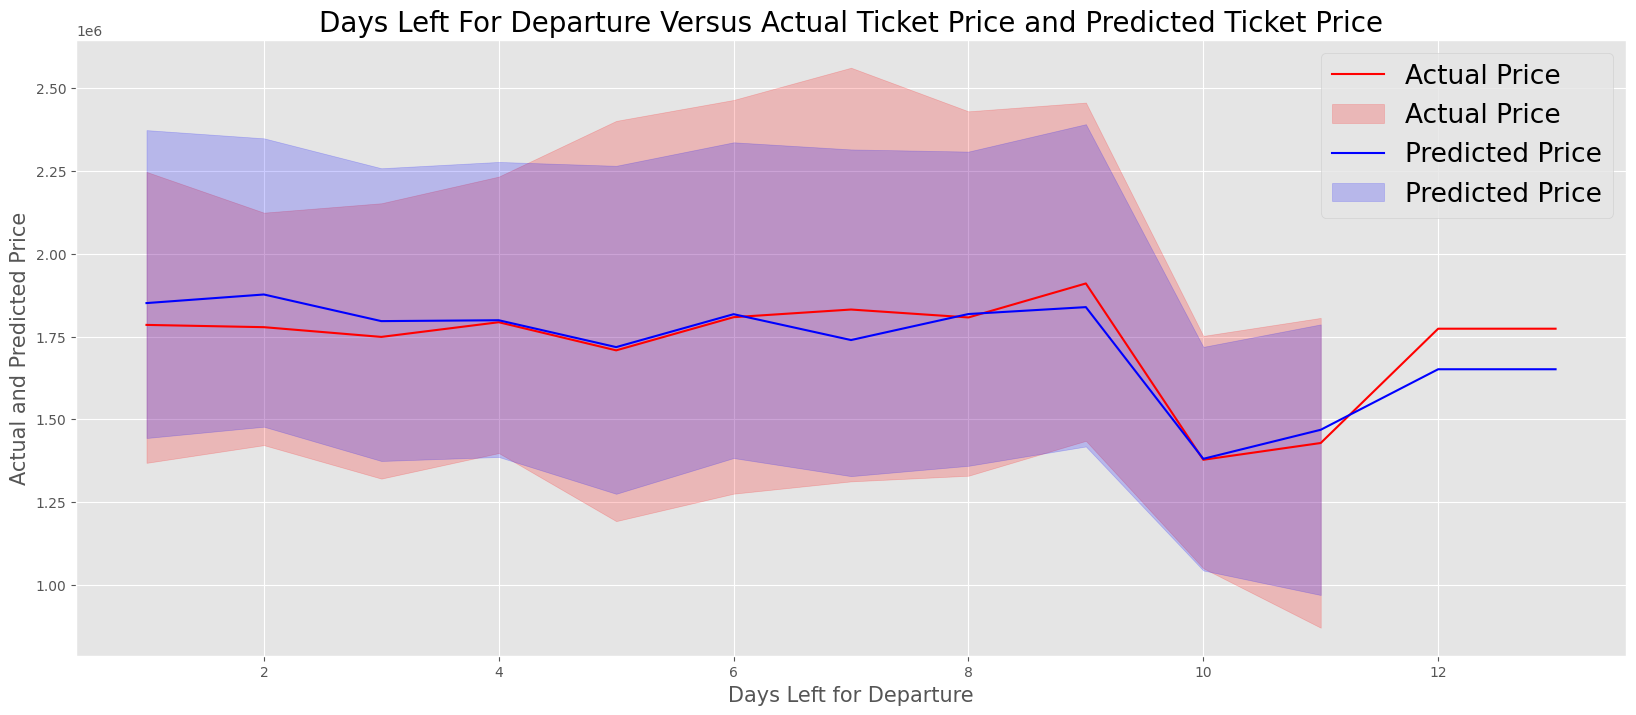

In [31]:
Bamboo_predicted = predict('Bamboo Airways', Bamboo_train)

Brand: VietJet Air, R2_score: 0.855071


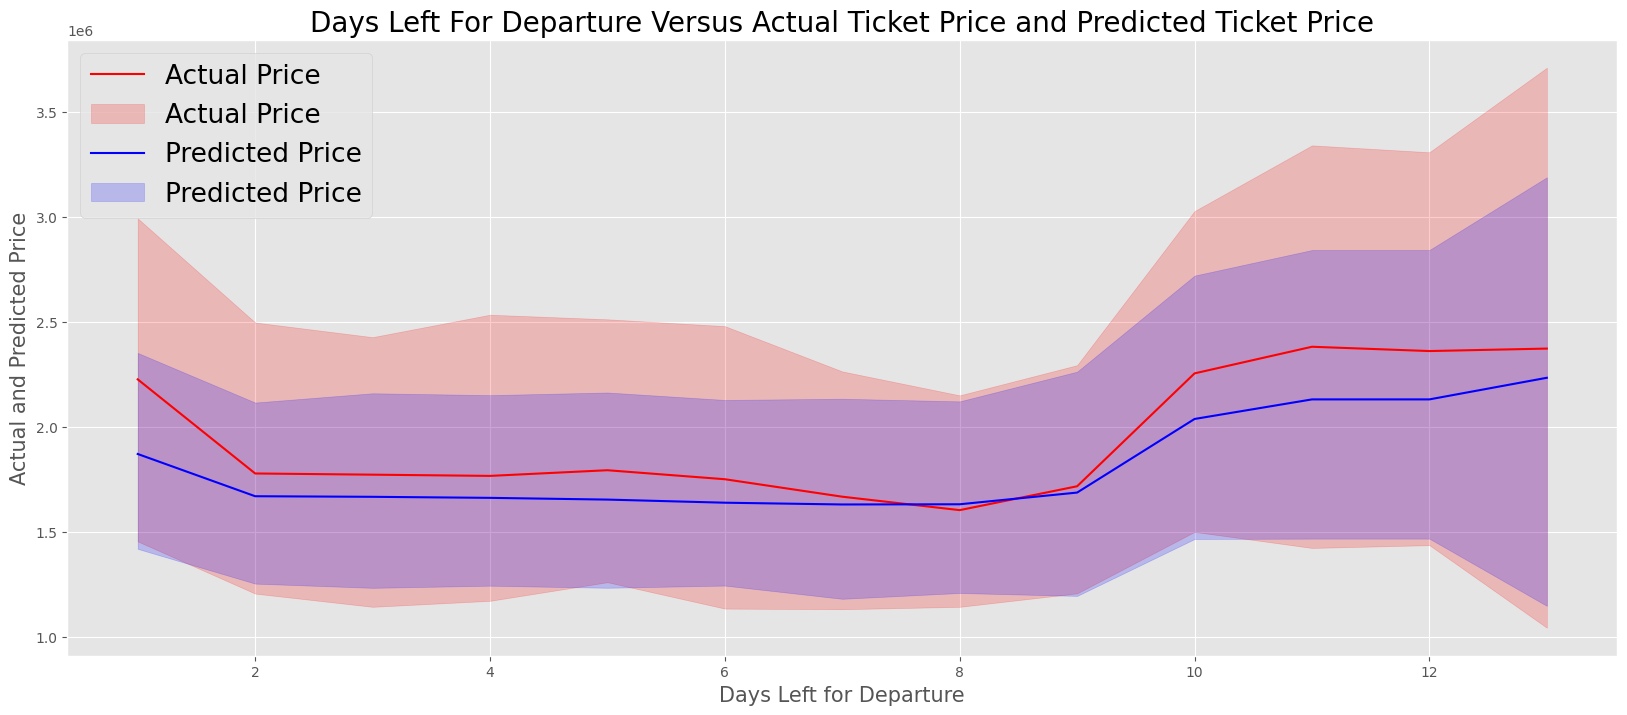

In [32]:
Vietjet_predicted = predict('VietJet Air', Vietjet_train)

Brand: Vietnam Airlines, R2_score: 0.720567


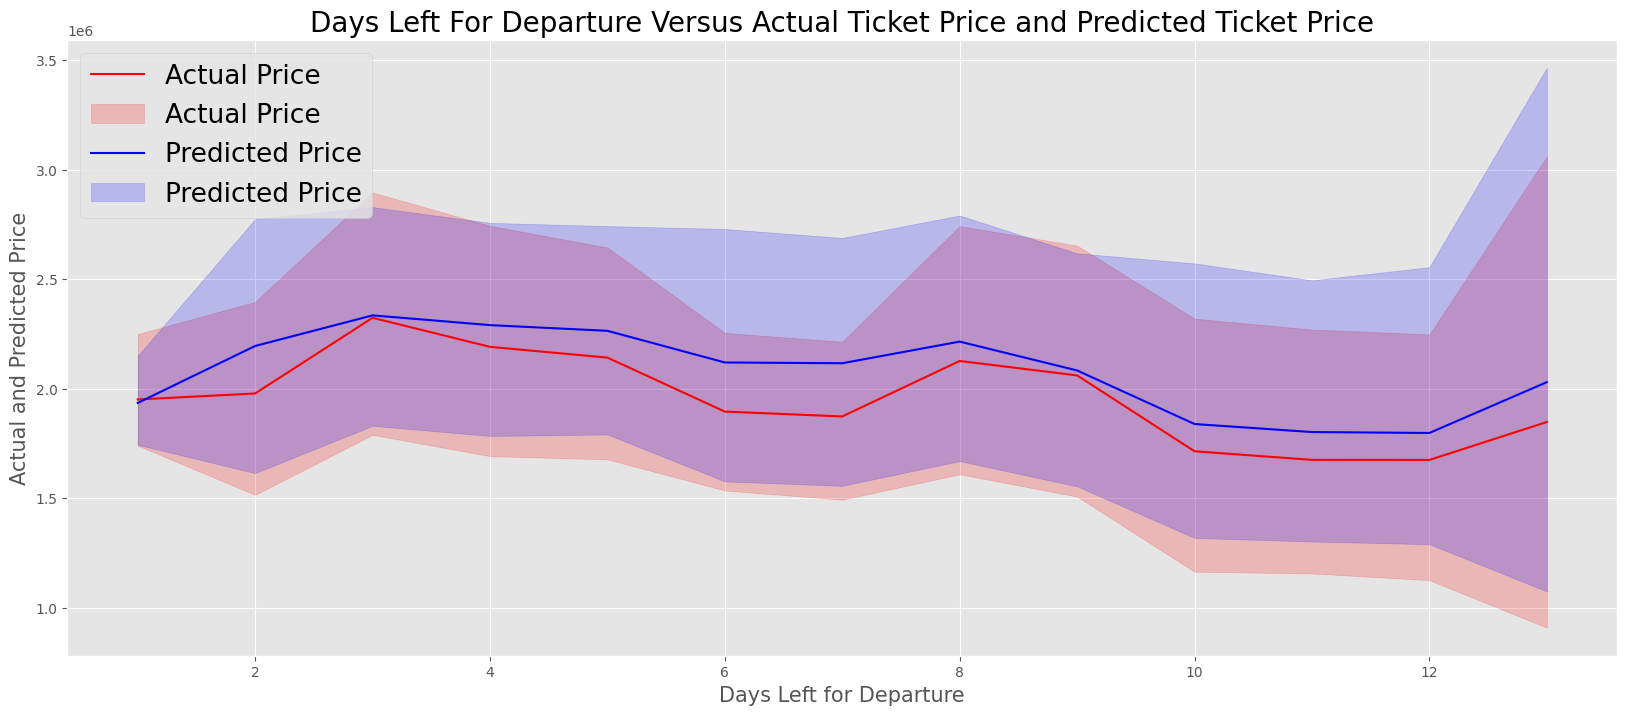

In [33]:
Vietnam_predicted = predict('Vietnam Airlines', Vietnam_train)

Brand: Vietravel Airlines, R2_score: 0.748937


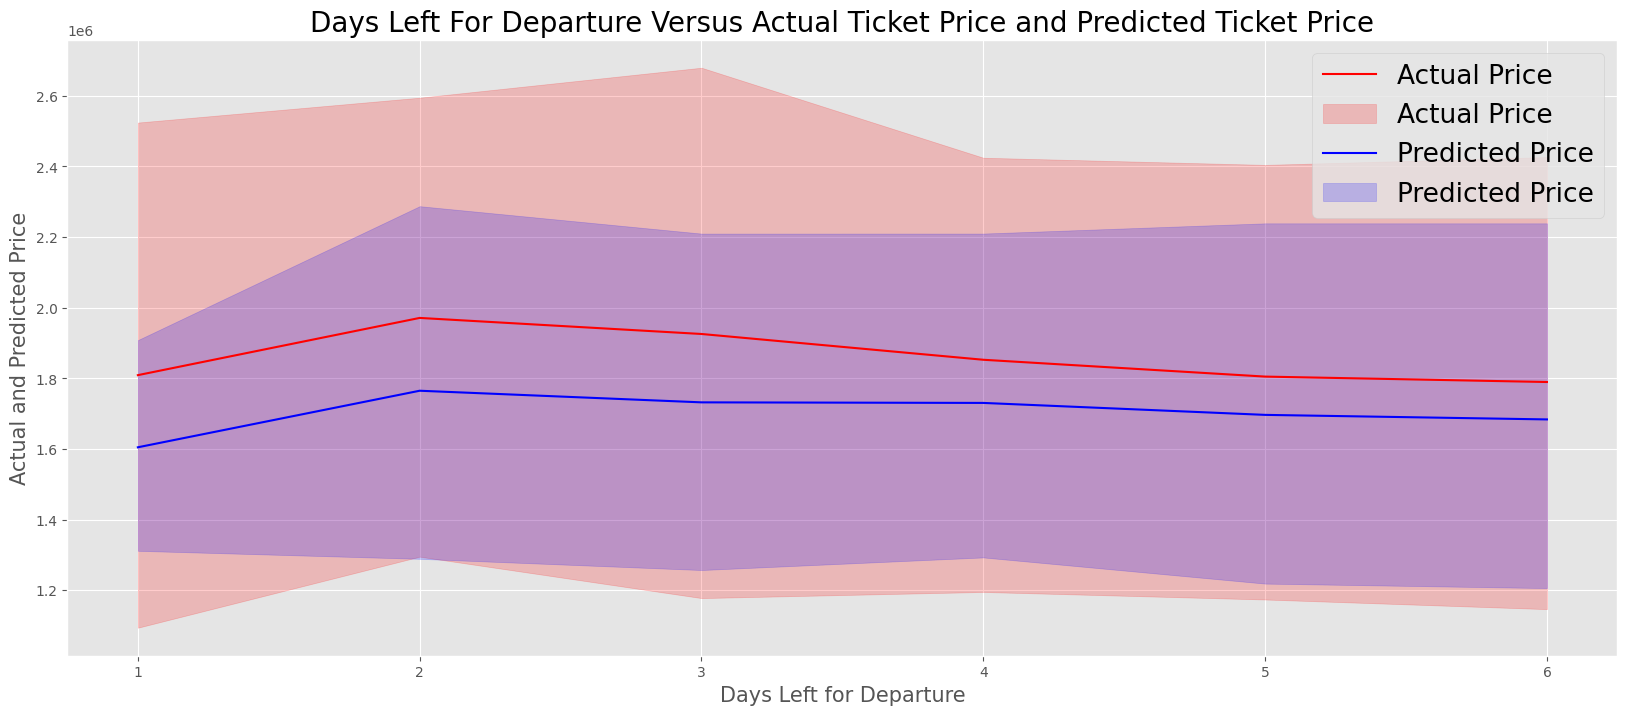

In [34]:
Vietravel_predicted = predict('Vietravel Airlines', Vietravel_train)

In [35]:
Bamboo_predicted.head()

,id,brand,price,destination,trip_mins,is_holiday,days_left,start_hour_Afternoon,start_hour_EarlyMorning,start_hour_Evening,start_hour_LateNight,start_hour_Morning,end_hour_Afternoon,end_hour_EarlyMorning,end_hour_Evening,end_hour_LateNight,end_hour_Morning,hand_luggage_7,hand_luggage_10,hand_luggage_12,checked_baggage_0,checked_baggage_20,checked_baggage_23,Actual Price,Predicted Price
0,DAD0027,Bamboo Airways,1825950,Đà Nẵng (DAD)\nSân bay Đà Nẵng,85,1,9,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,1773563,1.602115e+06
1,DAD0027,Bamboo Airways,1825950,Đà Nẵng (DAD)\nSân bay Đà Nẵng,85,1,8,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,1608343,1.597055e+06
2,DAD0027,Bamboo Airways,1825950,Đà Nẵng (DAD)\nSân bay Đà Nẵng,85,1,7,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,1730130,1.597055e+06
3,DAD0027,Bamboo Airways,1825950,Đà Nẵng (DAD)\nSân bay Đà Nẵng,85,1,6,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,1608343,1.597055e+06
4,DAD0027,Bamboo Airways,1825950,Đà Nẵng (DAD)\nSân bay Đà Nẵng,85,1,5,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,1773563,1.597055e+06


# tính threshold_price rẻ cho từng brand
- lấy 10% số giá vé dự đoán rẻ nhất
- tìm mean của 10% số lượng giá đó

In [36]:
def threshold_predicted(data):
    data['cheap_pred'] = 0
    data['actual_cheap'] = 0
    for des in data['destination'].unique():
        for id_value in data['id'].unique():
            des_df = data[(data['destination'] == des) &
                          (data['id'] == id_value)].copy()
            if des_df.empty:
                continue
            threshold_prices = des_df['Predicted Price']
            n = max(1, int(0.1 * len(threshold_prices)))
            cheap_threshold = threshold_prices.nsmallest(n)
            cheap_threshold = cheap_threshold.mean()

            cheapest_price = des_df['Actual Price'].min()
            data.loc[(data['id'] == id_value),
                     'cheap_threshold'] = cheap_threshold
            data.loc[(data['id'] == id_value) & (
                des_df['Predicted Price'] <= cheap_threshold), 'cheap_pred'] = 1
            data.loc[(data['id'] == id_value) & (cheapest_price ==
                                                 data['Actual Price']), 'actual_cheap'] = 1
            print(f"{des}-{id_value}: threshold = {cheap_threshold:.2f}")
    return data

In [37]:
Bamboo_predicted = threshold_predicted(Bamboo_predicted)

Đà Nẵng (DAD)
Sân bay Đà Nẵng-DAD0027: threshold = 1595234.30
Đà Nẵng (DAD)
Sân bay Đà Nẵng-DAD0002: threshold = 1465387.23
Hà Nội (HAN)
Sân bay Nội Bài-HAN0037: threshold = 2320511.16
Hà Nội (HAN)
Sân bay Nội Bài-HAN0030: threshold = 3177620.33
Hải Phòng (HPH)
Sân bay quốc tế Cát Bi-HPH0009: threshold = 1786019.21
Hải Phòng (HPH)
Sân bay quốc tế Cát Bi-HPH0004: threshold = 1783663.67
Phú Quốc (PQC)
Sân bay Phú Quốc-PQC0006: threshold = 961768.40
Phú Quốc (PQC)
Sân bay Phú Quốc-PQC0011: threshold = 1086842.99


In [38]:
Vietnam_predicted = threshold_predicted(Vietnam_predicted)

Nha Trang (CXR)
Sân bay Cam Ranh-CXR0176: threshold = 1072162.73
Nha Trang (CXR)
Sân bay Cam Ranh-CXR0188: threshold = 1056520.05
Đà Nẵng (DAD)
Sân bay Đà Nẵng-DAD0740: threshold = 1833423.72
Đà Nẵng (DAD)
Sân bay Đà Nẵng-DAD0506: threshold = 2104639.63
Hà Nội (HAN)
Sân bay Nội Bài-HAN0794: threshold = 3380081.88
Hà Nội (HAN)
Sân bay Nội Bài-HAN1087: threshold = 3036984.48
Hải Phòng (HPH)
Sân bay quốc tế Cát Bi-HPH0243: threshold = 2568830.69
Hải Phòng (HPH)
Sân bay quốc tế Cát Bi-HPH0253: threshold = 2956907.00
Phú Quốc (PQC)
Sân bay Phú Quốc-PQC0261: threshold = 1687160.77
Phú Quốc (PQC)
Sân bay Phú Quốc-PQC0309: threshold = 1549618.41


In [39]:
Vietravel_predicted = threshold_predicted(Vietravel_predicted)

Đà Nẵng (DAD)
Sân bay Đà Nẵng-DAD0764: threshold = 1681984.14
Đà Nẵng (DAD)
Sân bay Đà Nẵng-DAD0777: threshold = 1387334.30
Hà Nội (HAN)
Sân bay Nội Bài-HAN1282: threshold = 2517521.87
Hà Nội (HAN)
Sân bay Nội Bài-HAN1283: threshold = 2082486.07
Phú Quốc (PQC)
Sân bay Phú Quốc-PQC0332: threshold = 1072021.64
Phú Quốc (PQC)
Sân bay Phú Quốc-PQC0335: threshold = 927419.34


In [40]:
Vietjet_predicted = threshold_predicted(Vietjet_predicted)

Nha Trang (CXR)
Sân bay Cam Ranh-CXR0081: threshold = 794732.07
Nha Trang (CXR)
Sân bay Cam Ranh-CXR0037: threshold = 849156.66
Đà Nẵng (DAD)
Sân bay Đà Nẵng-DAD0208: threshold = 1650666.75
Đà Nẵng (DAD)
Sân bay Đà Nẵng-DAD0160: threshold = 1740132.65
Hà Nội (HAN)
Sân bay Nội Bài-HAN0322: threshold = 3087395.03
Hải Phòng (HPH)
Sân bay quốc tế Cát Bi-HPH0187: threshold = 1665661.11
Hải Phòng (HPH)
Sân bay quốc tế Cát Bi-HPH0054: threshold = 2365656.08
Phú Quốc (PQC)
Sân bay Phú Quốc-PQC0157: threshold = 1108821.85
Phú Quốc (PQC)
Sân bay Phú Quốc-PQC0114: threshold = 1149015.64


In [41]:
def lineplot(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
    axes = axes.flatten()

    i = 0
    for des in data['destination'].unique():
        print(
            f'Destination: {des}, count: {len(data[data["destination"] == des])}')
        df = data[data['destination'] == des]
        sns.lineplot(
            ax=axes[i],
            x='days_left',
            y='price',
            data=df,
            color='blue')
        axes[i].set_title(f'{df["brand"].unique()[0]} - {des}')
        axes[i].set_xlabel('Days Left')
        axes[i].set_ylabel('Price')
        i += 1

    # Ẩn các subplot còn thừa nếu có
    for j in range(i, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_price_trend(data):
    unique_ids = data['id'].unique()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes = axes.flatten()  # Chuyển về mảng 1 chiều

    for i, id_val in enumerate(unique_ids):
        df = data[data['id'] == id_val].sort_values('days_left')
        ax = axes[i]
        ax.plot(df['days_left'], df['Actual Price'], linestyle='-', marker='o',
                color='gray', alpha=0.6, label='Actual Price')
        ax.axhline(df['cheap_threshold'].iloc[0], color='blue', linestyle='--',
                   label=f'Threshold = {df["cheap_threshold"].iloc[0]:.2f}')
        ax.invert_xaxis()
        ax.set_title(f'ID: {id_val}')
        ax.set_xlabel('Days Left')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True)

    # Ẩn các subplot trống (nếu có)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Bamboo Airways - Đà Nẵng (DAD)
Sân bay Đà Nẵng


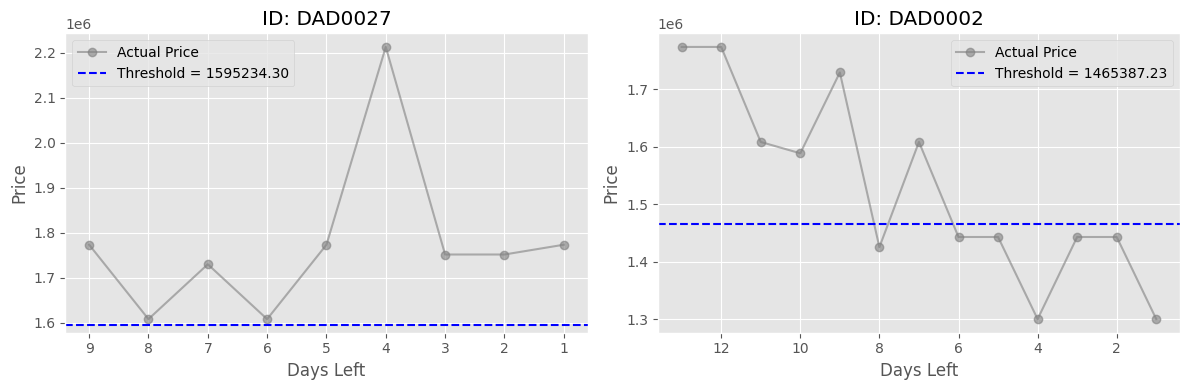

Bamboo Airways - Hà Nội (HAN)
Sân bay Nội Bài


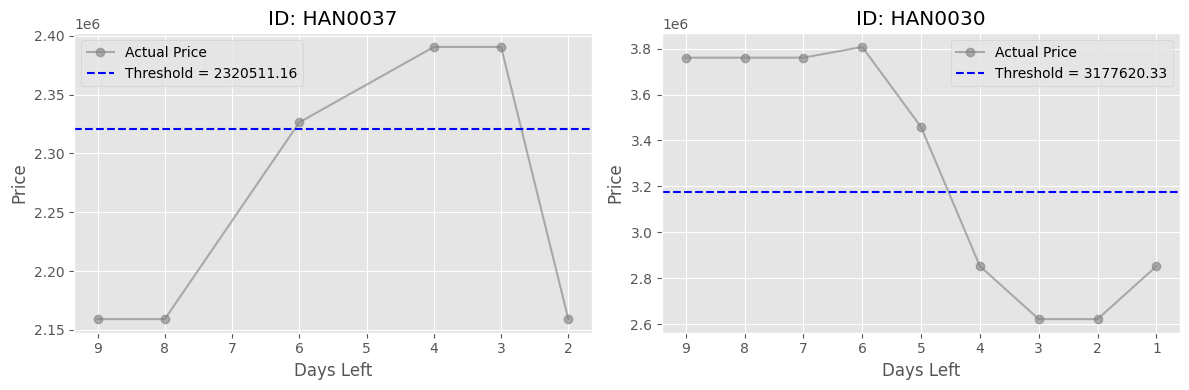

Bamboo Airways - Hải Phòng (HPH)
Sân bay quốc tế Cát Bi


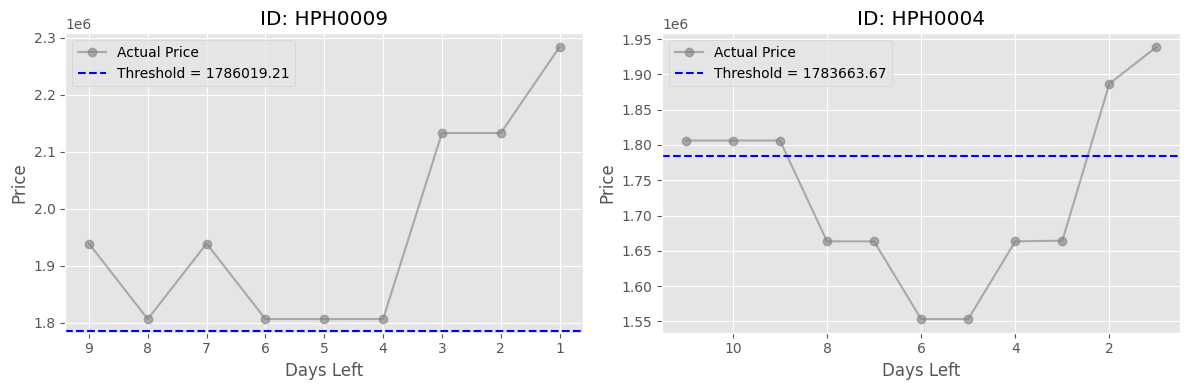

Bamboo Airways - Phú Quốc (PQC)
Sân bay Phú Quốc


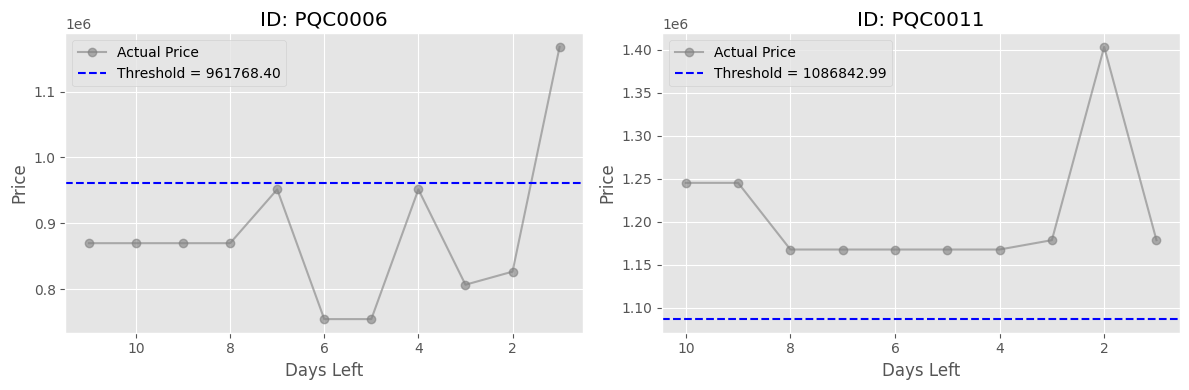

In [43]:
for des in Bamboo_predicted['destination'].unique():
    print(f'Bamboo Airways - {des}')
    plot_price_trend(Bamboo_predicted[Bamboo_predicted['destination'] == des])

Vietjet Air - Nha Trang (CXR)
Sân bay Cam Ranh


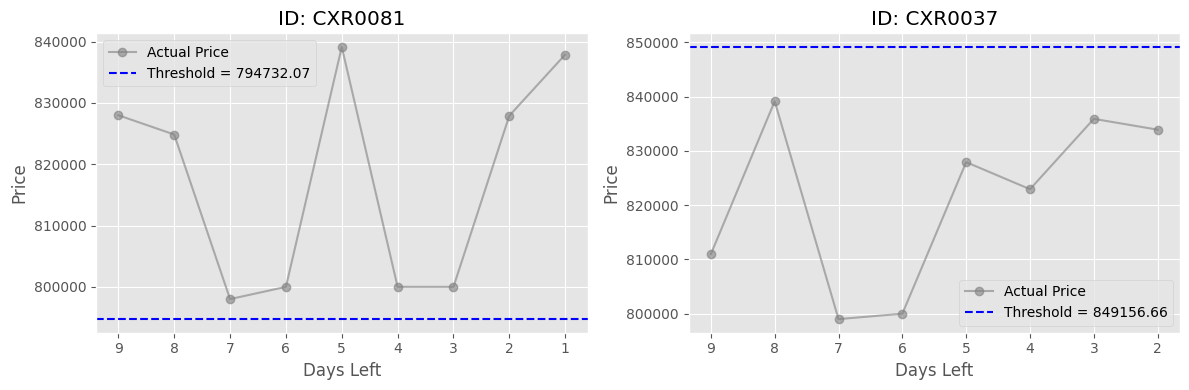

Vietjet Air - Đà Nẵng (DAD)
Sân bay Đà Nẵng


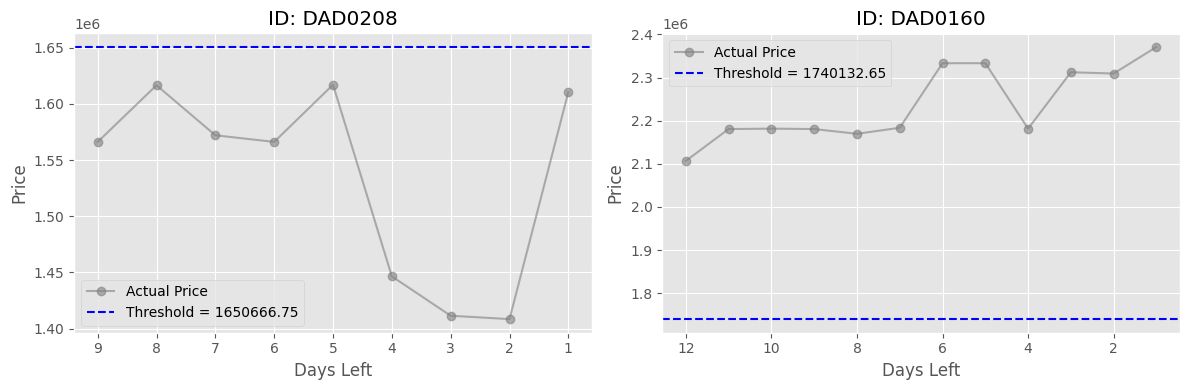

Vietjet Air - Hà Nội (HAN)
Sân bay Nội Bài


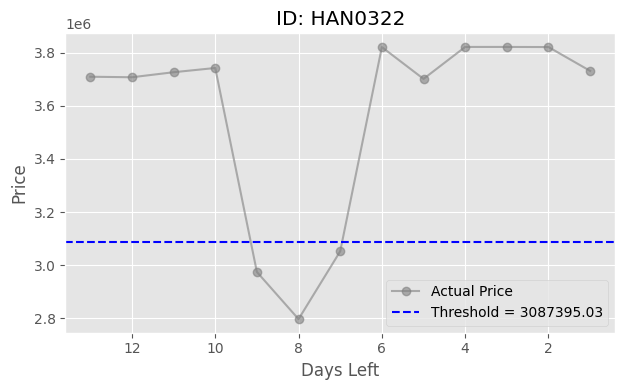

Vietjet Air - Hải Phòng (HPH)
Sân bay quốc tế Cát Bi


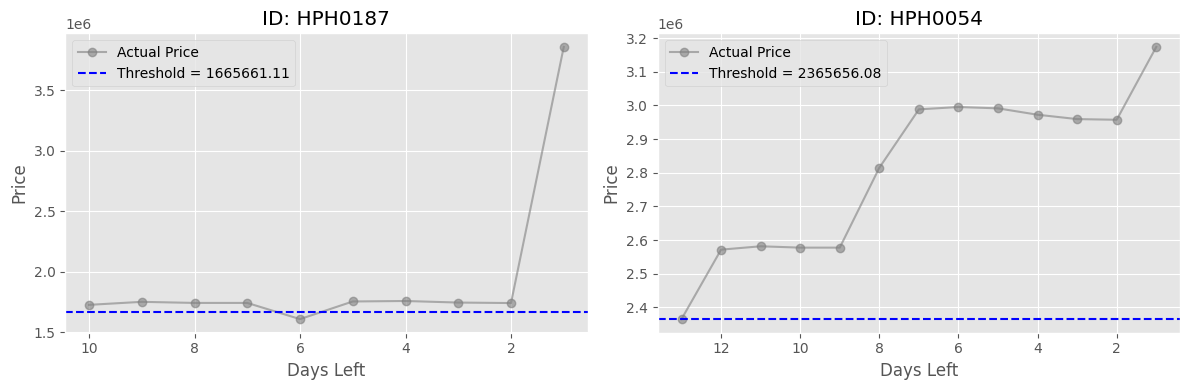

Vietjet Air - Phú Quốc (PQC)
Sân bay Phú Quốc


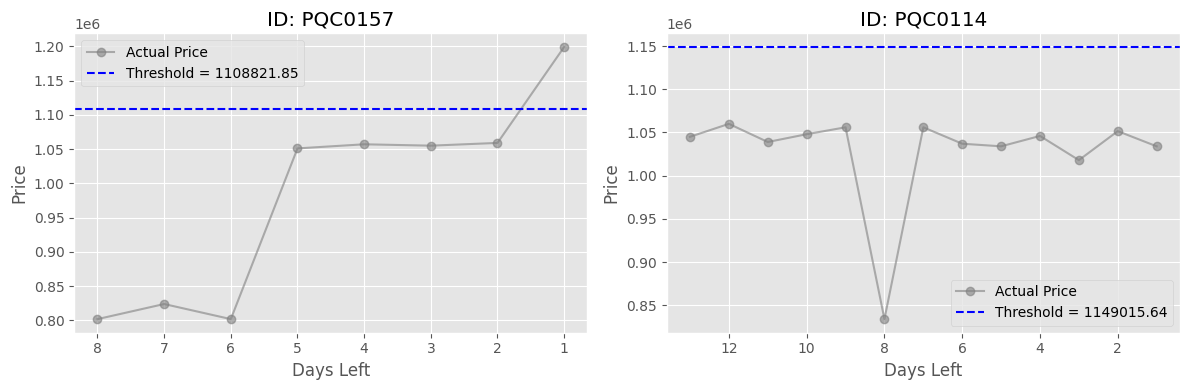

In [44]:
for des in Vietjet_predicted['destination'].unique():
    print(f'Vietjet Air - {des}')
    plot_price_trend(
        Vietjet_predicted[Vietjet_predicted['destination'] == des])

Vietnam Airlines - Nha Trang (CXR)
Sân bay Cam Ranh


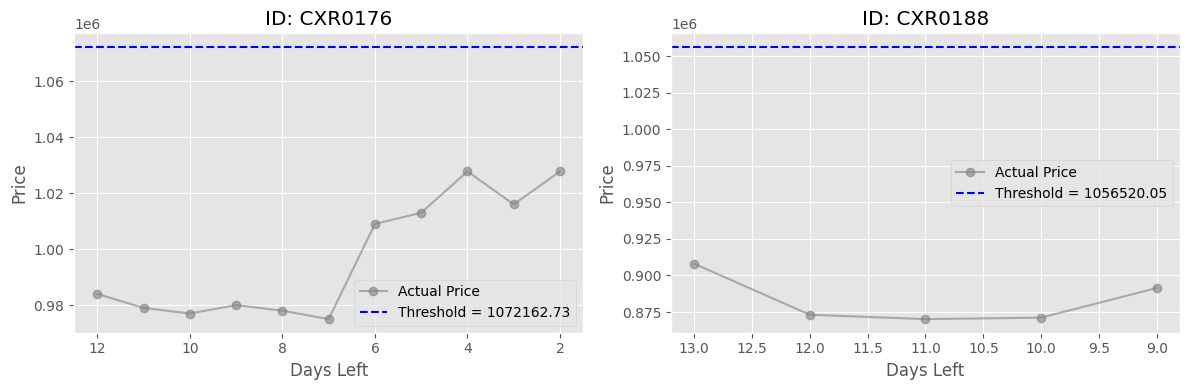

Vietnam Airlines - Đà Nẵng (DAD)
Sân bay Đà Nẵng


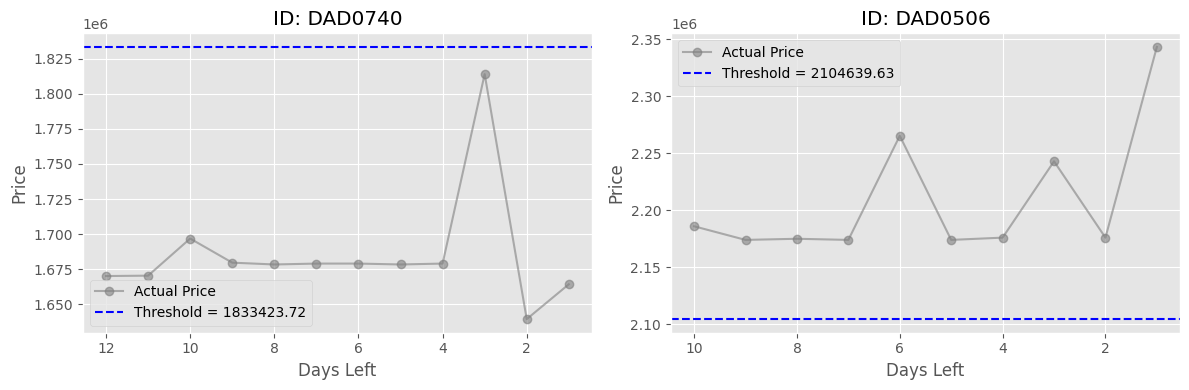

Vietnam Airlines - Hà Nội (HAN)
Sân bay Nội Bài


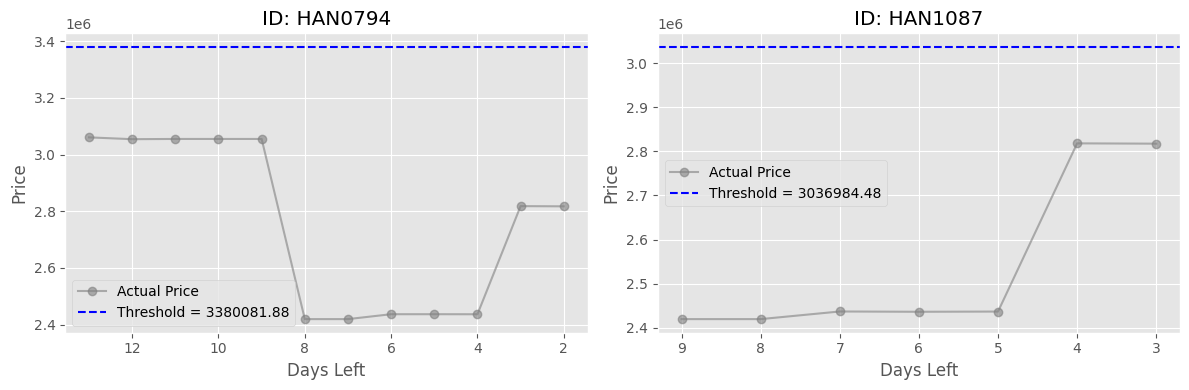

Vietnam Airlines - Hải Phòng (HPH)
Sân bay quốc tế Cát Bi


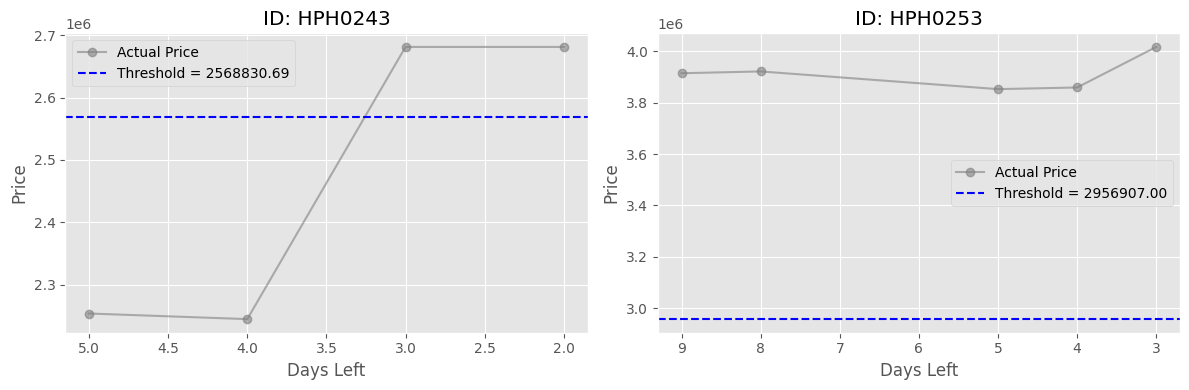

Vietnam Airlines - Phú Quốc (PQC)
Sân bay Phú Quốc


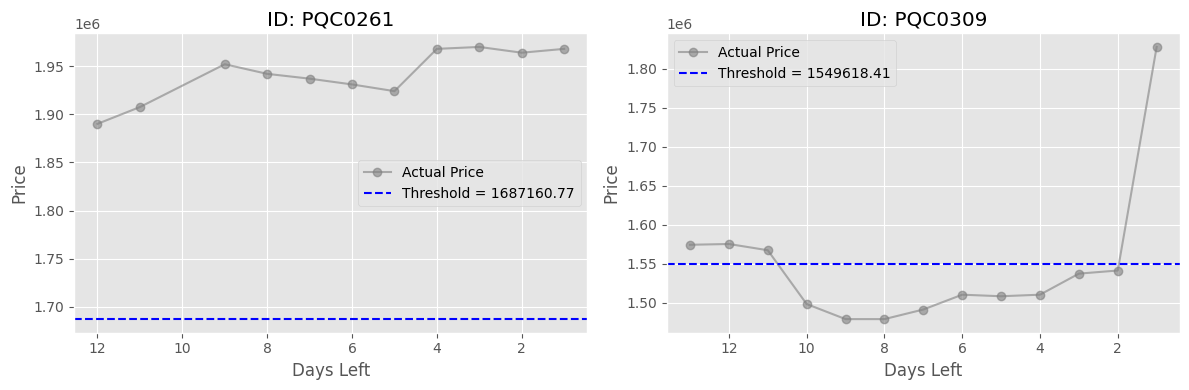

In [45]:
for des in Vietnam_predicted['destination'].unique():
    print(f'Vietnam Airlines - {des}')
    plot_price_trend(
        Vietnam_predicted[Vietnam_predicted['destination'] == des])

Vietravel - Đà Nẵng (DAD)
Sân bay Đà Nẵng


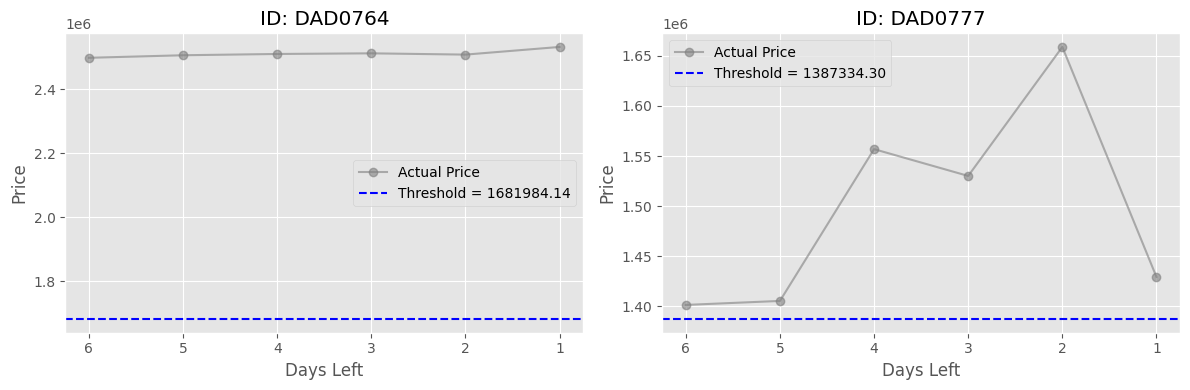

Vietravel - Hà Nội (HAN)
Sân bay Nội Bài


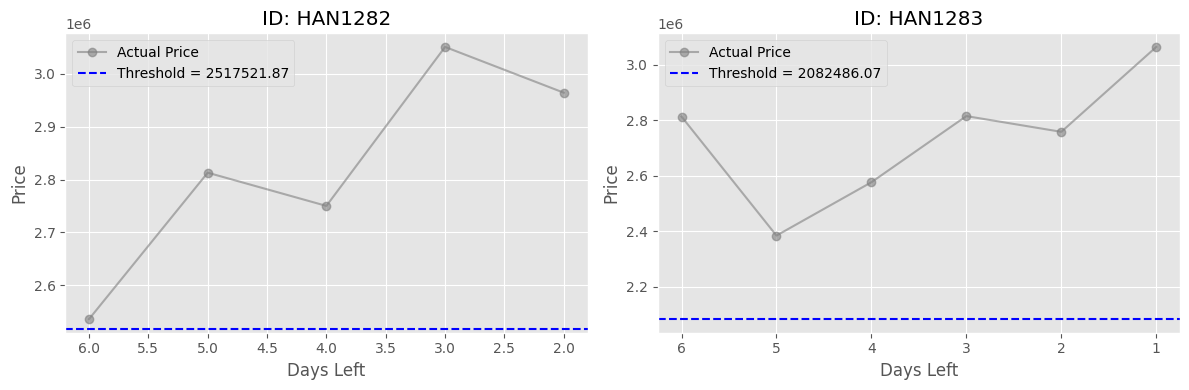

Vietravel - Phú Quốc (PQC)
Sân bay Phú Quốc


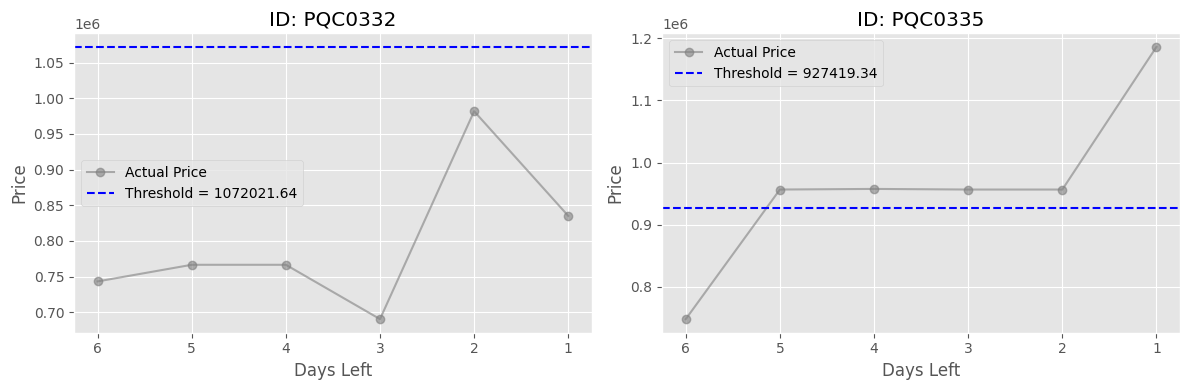

In [46]:
for des in Vietravel_predicted['destination'].unique():
    print(f'Vietravel - {des}')
    plot_price_trend(
        Vietravel_predicted[Vietravel_predicted['destination'] == des])

In [47]:
final_results = pd.concat([Vietnam_predicted,
                           Vietravel_predicted,
                           Bamboo_predicted,
                           Vietjet_predicted],
                          ignore_index=True)
final_results.head()

,id,brand,price,destination,trip_mins,is_holiday,days_left,start_hour_Afternoon,start_hour_EarlyMorning,start_hour_Evening,start_hour_LateNight,start_hour_Morning,end_hour_Afternoon,end_hour_EarlyMorning,end_hour_Evening,end_hour_LateNight,end_hour_Morning,hand_luggage_7,hand_luggage_10,hand_luggage_12,checked_baggage_0,checked_baggage_20,checked_baggage_23,Actual Price,Predicted Price,cheap_pred,actual_cheap,cheap_threshold
0,CXR0176,Vietnam Airlines,940059,Nha Trang (CXR)\nSân bay Cam Ranh,65,2,12,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,984015,1.176608e+06,0,0,1.072163e+06
1,CXR0176,Vietnam Airlines,940059,Nha Trang (CXR)\nSân bay Cam Ranh,65,2,11,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,979020,1.176608e+06,0,0,1.072163e+06
2,CXR0176,Vietnam Airlines,940059,Nha Trang (CXR)\nSân bay Cam Ranh,65,2,10,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,977022,1.075082e+06,0,0,1.072163e+06
3,CXR0176,Vietnam Airlines,940059,Nha Trang (CXR)\nSân bay Cam Ranh,65,2,9,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,980019,1.072163e+06,1,0,1.072163e+06
4,CXR0176,Vietnam Airlines,940059,Nha Trang (CXR)\nSân bay Cam Ranh,65,2,8,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,978021,1.072163e+06,1,0,1.072163e+06


In [48]:
tmp = final_results.groupby('id', as_index=False).first()[
    ['id', 'cheap_pred', 'actual_cheap']]
tmp

,id,cheap_pred,actual_cheap
0,CXR0037,1,0
1,CXR0081,1,0
2,CXR0176,0,0
3,CXR0188,0,0
4,DAD0002,0,0
5,DAD0027,0,0
6,DAD0160,0,1
7,DAD0208,1,0
8,DAD0506,1,0
9,DAD0740,1,0
